# First look at AGN data in Rubin DP1

Author: Olivia Lynn & Neven Caplar

Last Run: June 26, 2025

# How much data is there

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


Short answer: 2.3 million objects, 1.1 million diaObjects (https://data.lsdb.io/rubin#DP1/object_collection, https://data.lsdb.io/rubin#DP1/dia_object_collection)

More investigation here: Let’s first show how to use the Butler, the LSST Science Pipelines’ data access framework. The Butler provides a standardized and scalable interface to retrieve raw and processed data products from the Rubin data repository, using a combination of dataset types, collections, and metadata. This is the default way to access data on the Rubin Science Platform, whether you’re working with images, catalogs, or calibration products. Below, we initialize a Butler instance pointing to the ComCam Data Preview 1 (DP1) processing run.

In [2]:
from lsst.daf.butler import Butler 
repo = '/repo/main'
instrument = "LSSTComCam"
butler = Butler(repo, collections='LSSTComCam/runs/DRP/DP1/v29_0_0_rc6/DM-50098', instrument=instrument)

In [3]:
# how many difference Exposures are there for each band?
# basically - how many detectors are there for each band?
bands = ["u", "g", "r", "i", "z", "y"]
verbose = False

# Define bands and their colors
band_colors = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'brown',
    'z': 'purple',
    'y': 'orange'
}

for band in bands:
    datasetRefs_dia = butler.query_datasets("difference_image", where=f"band='{band}'")    

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 938 differenceExps for band 'u'
Found 4206 differenceExps for band 'g'
Found 4884 differenceExps for band 'r'
Found 2798 differenceExps for band 'i'
Found 2565 differenceExps for band 'z'
Found 581 differenceExps for band 'y'


We now compute the number of tracts that contain diaSources and diaObjects.
In the LSST data model, a tract is a large, fixed region of the sky defined by the survey’s sky tessellation system.
The full sky is divided into tracts to enable parallel processing and efficient spatial indexing. Each tract is further subdivided into smaller patches. Tracts serve as the fundamental unit for organizing and querying data products like images, sources, and object catalogs.


In [4]:

lc_refs = butler.query_datasets("dia_source")
obj_refs = butler.query_datasets("dia_object")

print(len(lc_refs))
print(len(obj_refs))

25
25


## Now lets look at the distribution of diaSources with magnitude

In [5]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tqdm(tract_indices):
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref

    try:
        # Fetch diaObj for this tract
        dia_Obj = butler.get(obj_ref)
        dia_Obj_list.append(dia_Obj)
    except FileNotFoundError:
        print(f"Warning: diaObj not found for tract {obj_ref.dataId['tract']}. Skipping.")

    try:
        # Fetch diaSource for this tract
        diaSource = butler.get('dia_source', dataId=obj_ref.dataId)
        diaSource_list.append(diaSource)
    except FileNotFoundError:
        print(f"Warning: diaSource not found for tract {obj_ref.dataId['tract']}. Skipping.")

# Concatenate all diaObj and diaSource DataFrames if they contain data
dia_Obj = pd.concat(dia_Obj_list, ignore_index=False) if dia_Obj_list else pd.DataFrame()
diaSource = pd.concat(diaSource_list, ignore_index=False) if diaSource_list else pd.DataFrame()

100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


In [6]:
# There are no magntitudes in the diaSource table, so we have to create it fromfrom the fluxes
def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

In [7]:
# Lets import the plotting functions for lsst 
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_symbols, get_multiband_plot_linestyles, publication_plots

x = np.linspace(0, 10, 100)
colors_white = get_multiband_plot_colors()
symbols = get_multiband_plot_symbols()
line_styles = get_multiband_plot_linestyles()
publication_plots.set_rubin_plotstyle()

bands_dict = publication_plots.get_band_dicts()

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


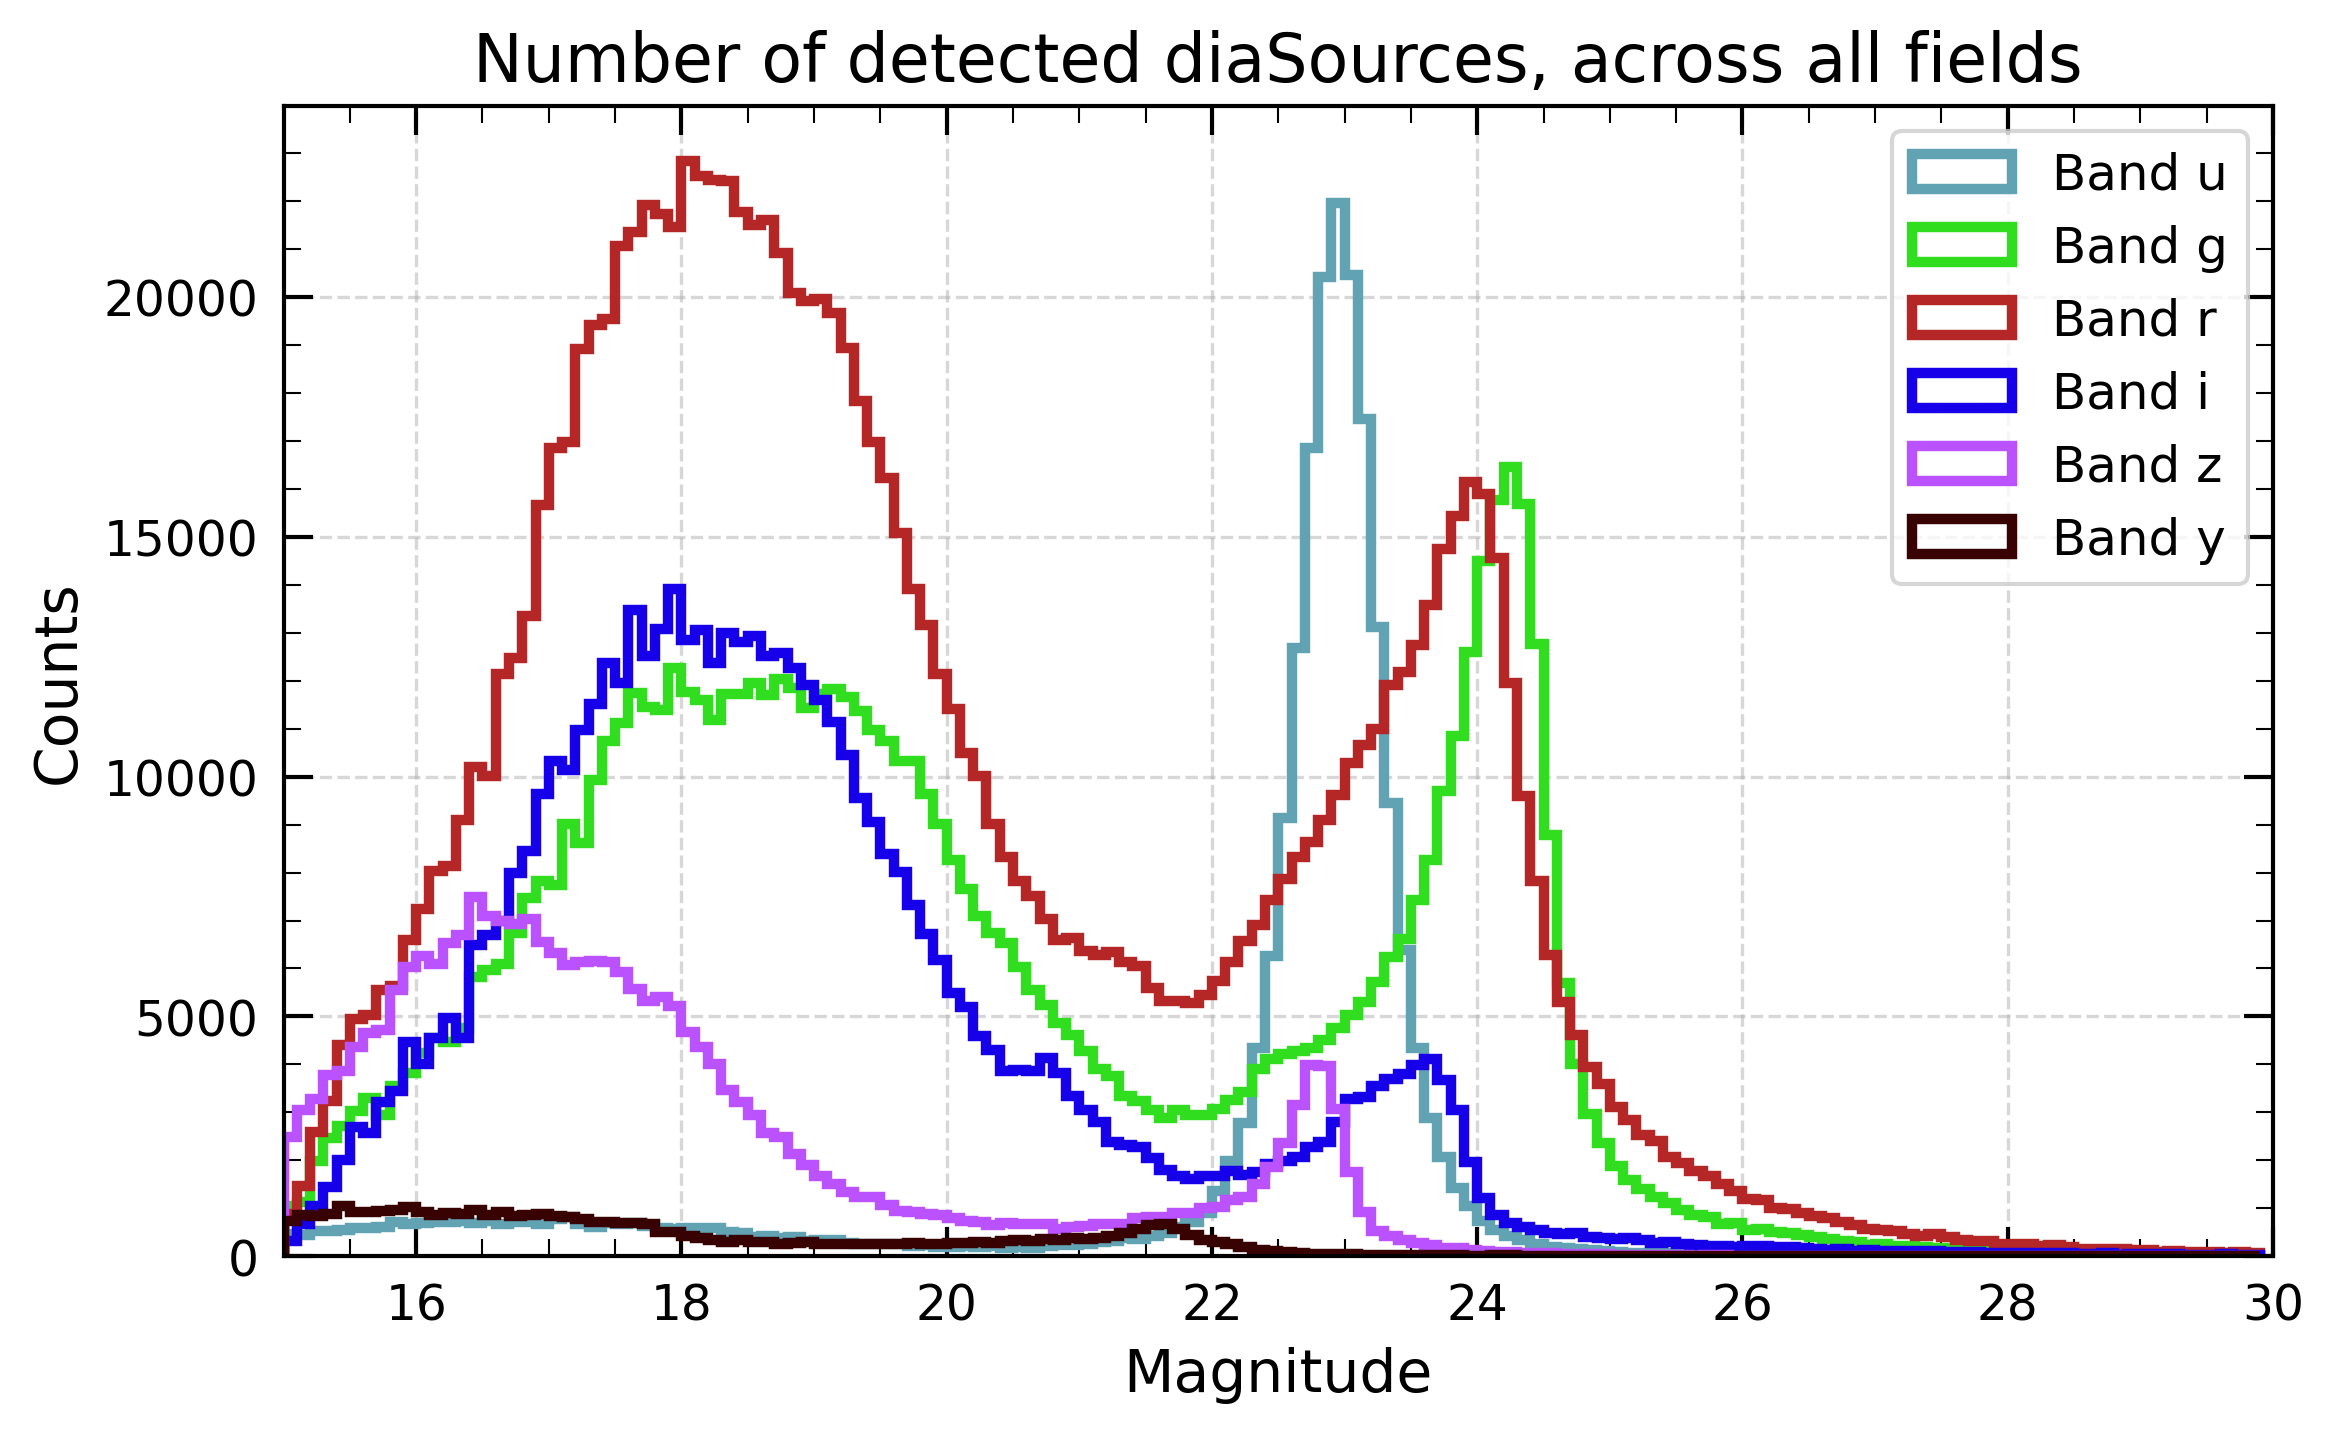

In [8]:
# Compute scienceMag
diaSource.loc[:, 'scienceMag'] = create_mag(diaSource['scienceFlux'].values)

# Define your bands (adjust to your actual values if needed)
bands = ["u", "g", "r", "i", "z", "y"]

# Plot: one figure, six lines (one per band)
plt.figure(figsize=(8, 5))
plt.title('Number of detected diaSources, across all fields', fontsize=16)

for band in bands:
    band_data = diaSource[diaSource['band'] == band]
    
    if not band_data.empty:
        plt.hist(
            band_data['scienceMag'],
            bins=np.arange(15, 30, 0.1),
            histtype='step',
            linewidth=2.5,
            color=bands_dict['colors'][band],  # Use the color corresponding to the band        
            label=f'Band {band}'
        )

# Plot formatting
plt.xlabel('Magnitude', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xlim(15, 30)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Set up LSDB

Goal of LSDB (see more on lsdb.io):

Provide a user friendly distributed framework for working with catalog data

● Enable straightforward all-sky and time series analysis

● Crossmatch large catalogs within minutes

● Usable on HPC, cloud, or local compute

● Minimal setup required (i.e. do not need to configure and run a spark server)


In [9]:
import lsdb
print(lsdb.__version__)
import hats
print(hats.__version__)
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import pandas as pd
plt.rcdefaults()

from lsdb.core.search import ConeSearch

from dask.distributed import Client
from nested_pandas import NestedDtype

0.6.0
0.6


In [10]:
# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Assign colors and linestyles
# Red for extragalactic fields, orange for dense fields
field_styles = {
    "ECDFS": ("red", "solid"),
    "EDFS": ("red", "dashed"),
    "Rubin_SV_38_7": ("red", "dotted"),
    "Rubin_SV_95_-25": ("orange", "solid"),
    "47_Tuc": ("orange", "dashed"),
    "Fornax_dSph": ("orange", "dotted"),
}

# Define a 2-degree (2*3600 arcseconds) search radius
radius_arcsec = 4 * 3600  # Convert 2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

To enable scalable and efficient computation, LSDB builds on top of Dask, a flexible parallel computing library for Python. Dask allows LSDB to operate on large astronomical catalogs using distributed or multi-threaded execution, while maintaining a familiar pandas-like API. Below, we configure a local Dask cluster with 4 workers, each constrained to 24 GB of memory and a single thread, which provides predictable and efficient parallelism for interactive analysis.

In [11]:
client = Client(n_workers=4, memory_limit="24GB", threads_per_worker=1)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:11769
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:26491'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:6905'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:26667'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:2523'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:31371 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:31371
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:18996
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:4741 name: 0
INFO:dis

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 89.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:11769,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 89.41 GiB
Comm: tcp://127.0.0.1:4741,Total threads: 1
Dashboard: http://127.0.0.1:7933/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:26491,


INFO:distributed.scheduler:Remove client Client-9b60754d-529b-11f0-8c7e-303ea7003400
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:19022; closing.
INFO:distributed.scheduler:Remove client Client-9b60754d-529b-11f0-8c7e-303ea7003400
INFO:distributed.scheduler:Close client connection: Client-9b60754d-529b-11f0-8c7e-303ea7003400
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1750948930.4553223') (0, 1, 2, 3)
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:18990; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:19008; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:18998; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:4741 name: 0 (stimulus_id='handle-worker-cleanup-1750948930.4625776')
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:10891 name: 1 (stimulus_id='handle-worker-cleanup-1750948930.4631903')
INFO:distributed.sche

## Get the data to crossmatch



In [12]:
# Open the LSDB catalog for ComCam data 
comcam_cat = lsdb.open_catalog('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/object_collection')
comcam_cat_lite = lsdb.open_catalog('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/object_collection_lite')
comcam_cat_dia = lsdb.open_catalog('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/dia_object_collection')


comcam_cat

,coord_dec,coord_decErr,coord_ra,coord_raErr,g_psfFlux,g_psfFluxErr,g_psfMag,g_psfMagErr,i_psfFlux,i_psfFluxErr,i_psfMag,i_psfMagErr,objectId,patch,r_psfFlux,r_psfFluxErr,r_psfMag,r_psfMagErr,refBand,refFwhm,shape_flag,shape_xx,shape_xy,shape_yy,tract,u_psfFlux,u_psfFluxErr,u_psfMag,u_psfMagErr,x,xErr,y,y_psfFlux,y_psfFluxErr,y_psfMag,y_psfMagErr,yErr,z_psfFlux,z_psfFluxErr,z_psfMag,z_psfMagErr,objectForcedSource
npartitions=389,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 130",double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],float[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<band: [string], coord_dec: [double], co..."
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
# The Milliquas catalog is a compiled quasar candidate catalog used here as a reference dataset for cross-matching and AGN identification.
miliquas_cat = lsdb.read_hats(
    "/sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8",
    margin_cache="/sdf/data/rubin/u/olynn/AGNs/hats/Milliquas_v8_margin/Milliquas_v8_10arcs",
)

miliquas_cat

,RA,DEC,NAME,TYPE,RMAG,BMAG,COMMENT,R,B,Z,CITE,ZCITE,XNAME,RNAME,LOBE1,LOBE2
npartitions=12,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 0",double[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],float[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow]
"Order: 0, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Do the crossmatch

LSDB uses lazy loading to defer reading and processing data until explicitly needed, allowing users to construct complex queries without immediate computation.
Calling .compute() triggers the actual data loading and execution, materializing the result as a concrete, in-memory pandas-like object for analysis.

In [14]:
comcam_x_milliquas = comcam_cat_lite.crossmatch(miliquas_cat, suffixes=["_COM", "_MIL"], radius_arcsec=.1)
comcam_x_milliquas_computed = comcam_x_milliquas.compute()

In [15]:
# let us save the cross-matched catalog to a Parquet file for further analysis or sharing
comcam_x_milliquas_computed.to_parquet("/sdf/home/n/ncaplar/AGN/comcam_x_milliquas_computed.parquet") # The output file path

## Verify crossmatch


/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:298: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


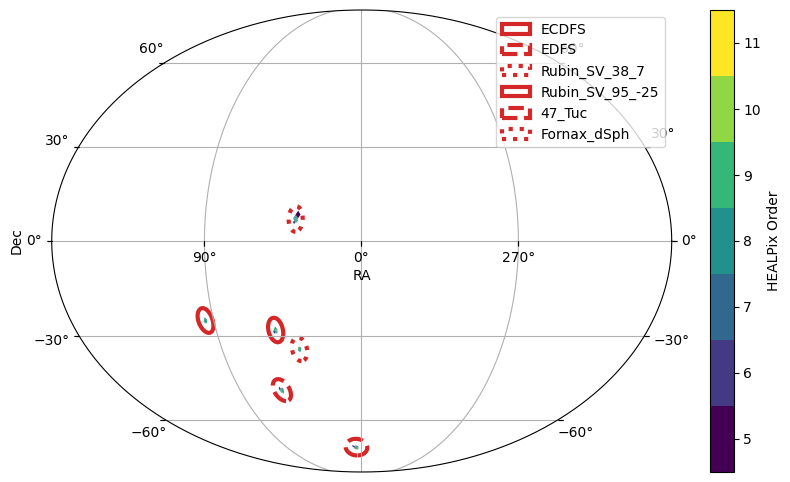

In [16]:
# Create the figure
fig = plt.figure(figsize=(10, 6))

# Plot pixel density map and capture axes
_, ax = comcam_x_milliquas.plot_pixels(fig=fig, plot_title="COMCAM x Milliquas")

# Loop over and plot each cone on the same axes
for name, cone in cones.items():
    color, linestyle = field_styles[name]
    cone.plot(ax=ax, edgecolor=color, facecolor="none", linewidth=3, linestyle=linestyle, label=name)

# Legend and display
ax.legend(loc="upper right")
plt.show()

In [17]:
client.close()

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:26491'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:6905'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:26667'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:2523'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:26491' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:2523' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:26667' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:6905' closed.


# Science 

Total number of object that got crossmatched - note this is only the closest crossmatch!

In [18]:
len(comcam_x_milliquas_computed)

646

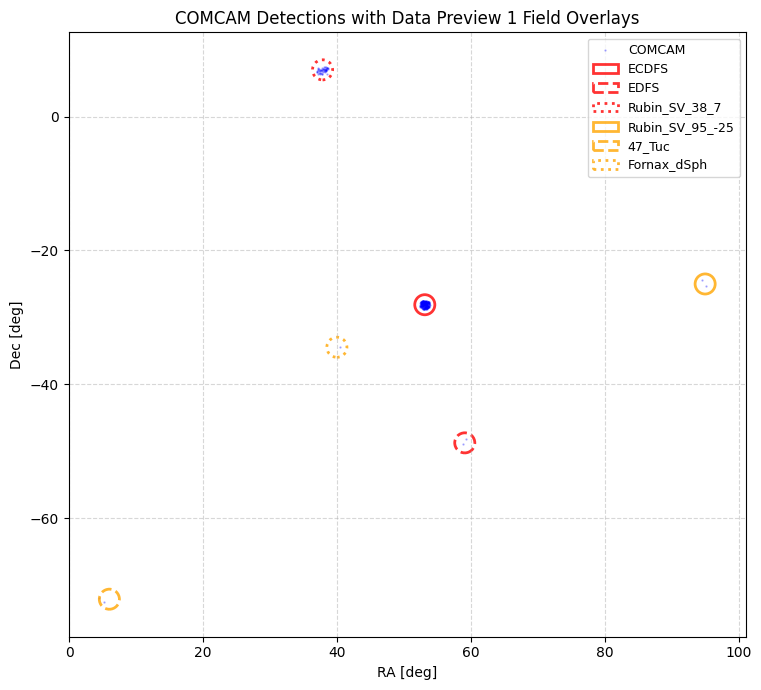

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter COMCAM sources
ax.scatter(
    comcam_x_milliquas_computed['coord_ra_COM'],
    comcam_x_milliquas_computed['coord_dec_COM'],
    s=0.4,
    c='blue',
    alpha=0.3,
    label='COMCAM'
)

# Draw each field as a circle
field_radius = 1.5  # degrees
for name, (ra, dec) in fields.items():
    color, linestyle = field_styles[name]
    circle = Circle(
        (ra, dec),
        radius=field_radius,
        edgecolor=color,
        facecolor='none',
        linestyle=linestyle,
        linewidth=2,
        alpha=0.8,
        label=name
    )
    ax.add_patch(circle)

# Labels and formatting
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.set_title("COMCAM Detections with Data Preview 1 Field Overlays")
ax.legend(fontsize=9)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


We’re previewing the first few rows of the cross-matched dataset, which includes RA/Dec coordinates and the nested objectForcedSource_COM column containing time-series photometry. LSDB uses nested-pandas, an extension of pandas that enables efficient handling of hierarchical or array-like data structures within a single DataFrame—ideal for representing per-object light curves alongside catalog metadata.

In [20]:
comcam_x_milliquas_computed[['coord_ra_COM','coord_ra_COM','objectForcedSource_COM']].head(5)


coord_ra_COM  coord_ra_COM  \
_healpix_29                                    
9583286184993797     37.784845     37.784845   
9589207111731327     38.493227     38.493227   
9601744588162284     38.280597     38.280597   
9605063056789129     38.325578     38.325578   
9606443063715214     37.703596     37.703596   

                                             objectForcedSource_COM  
_healpix_29                                                          
9583286184993797  [{band: 'r', coord_dec: 6.401704, coord_ra: 37...  
9589207111731327  [{band: 'r', coord_dec: 6.42791, coord_ra: 38....  
9601744588162284  [{band: 'r', coord_dec: 6.679054, coord_ra: 38...  
9605063056789129  [{band: 'r', coord_dec: 6.810459, coord_ra: 38...  
9606443063715214  [{band: 'r', coord_dec: 6.363172, coord_ra: 37...

In [21]:
# Count the number of detections in each band for each object
# This will create a new column for each band with the count of detections
bands = ["u", "g", "r", "i", "z", "y"]

def count_bands(entry):
    result = {}
    for band in bands:
        try:
            result[band] = (entry['band'] == band).sum()
        except Exception:
            result[band] = 0
    return result


# Apply to each row
band_counts = comcam_x_milliquas_computed["objectForcedSource_COM"].apply(count_bands)
# Turn into a proper DataFrame
band_counts_df = pd.DataFrame(band_counts.tolist()).fillna(0).astype(int)

# Add to original
for band in bands:
    comcam_x_milliquas_computed[f"n_{band}"] = band_counts_df[band].values

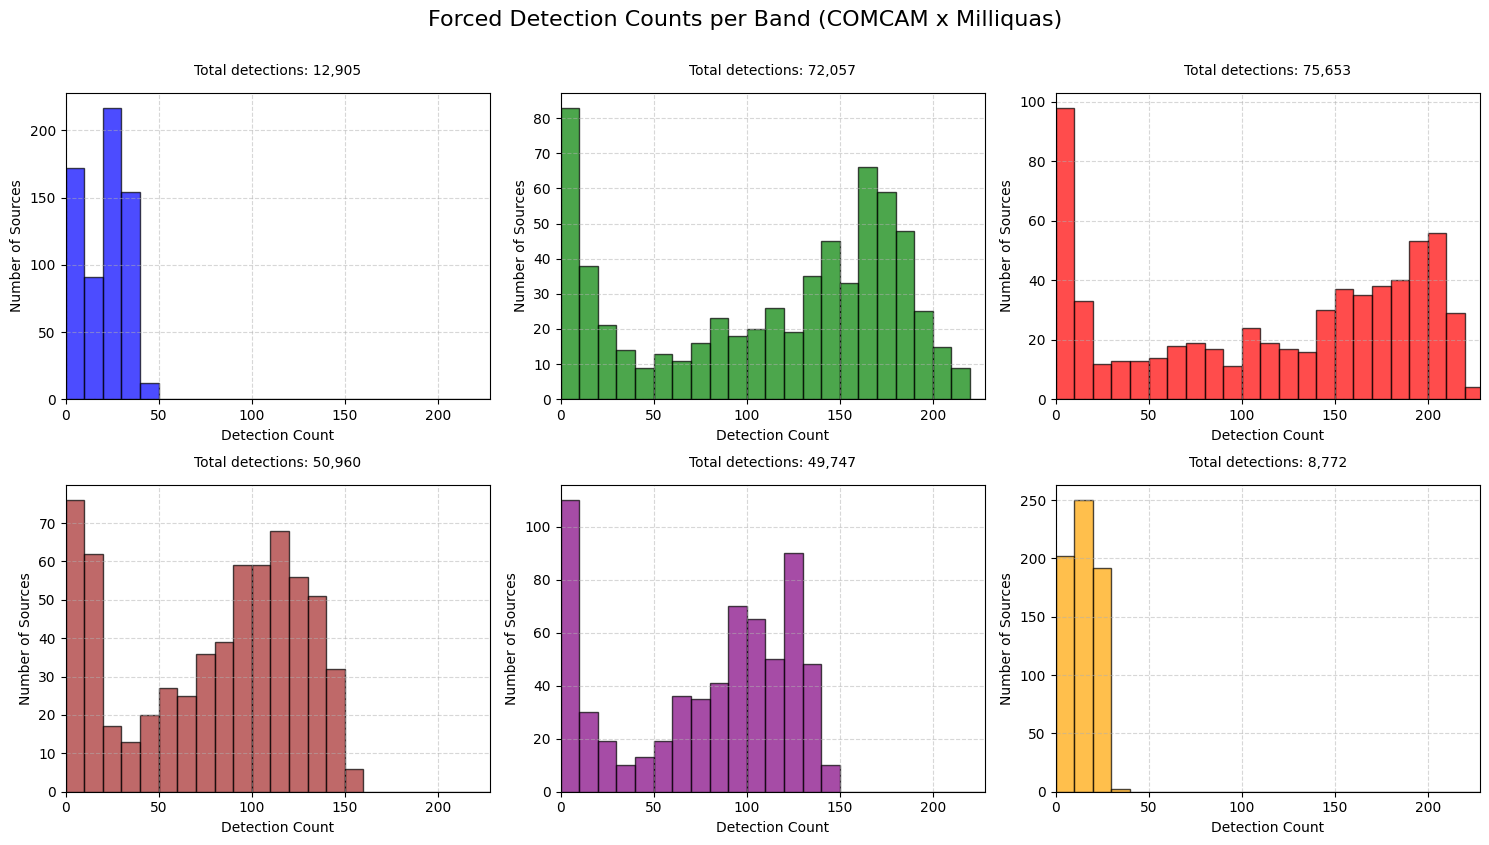

In [22]:
bands = [
    ('n_u', 'blue'),
    ('n_g', 'green'),
    ('n_r', 'red'),
    ('n_i', 'brown'),
    ('n_z', 'purple'),
    ('n_y', 'orange'),
]

# Determine common bin range
all_counts = pd.concat([comcam_x_milliquas_computed[band] for band, _ in bands])
bin_min, bin_max = int(all_counts.min()), int(all_counts.max()) + 1
bins = list(range(bin_min, bin_max + 10, 10))  # Bin width = 10

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (band, color) in zip(axes, bands):
    data = comcam_x_milliquas_computed[band].dropna()
    total_detections = int(data.sum())
    
    ax.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.7)
    ax.set_xlabel("Detection Count")
    ax.set_ylabel("Number of Sources")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(bin_min, bin_max)

    # Add total detection count above the plot
    ax.text(0.5, 1.05, f"Total detections: {total_detections:,}", 
            transform=ax.transAxes, ha='center', va='bottom', 
            fontsize=10, color='black')

plt.tight_layout()
plt.suptitle("Forced Detection Counts per Band (COMCAM x Milliquas)", fontsize=16, y=1.05)
plt.show()

## Plot lightcurves

Let's finally plot some light curves! Lets start with an early rising SNe just for fun! 

In [23]:
%%time
comcam_cat_single = comcam_cat.id_search(values={"objectId": 609782208097434045}).compute()
comcam_cat_single

CPU times: user 1.67 s, sys: 141 ms, total: 1.81 s
Wall time: 1.41 s


coord_dec  coord_decErr   coord_ra  coord_raErr  \
_healpix_29                                                            
2528690302715554183 -28.279956      0.000001  52.838373     0.000001   

                       g_psfFlux  g_psfFluxErr   g_psfMag  g_psfMagErr  \
_healpix_29                                                              
2528690302715554183  9667.056641      12.95607  21.436764     0.001455   

                       i_psfFlux  i_psfFluxErr  ...     y_psfFlux  \
_healpix_29                                     ...                 
2528690302715554183  25888.34375     28.112823  ...  38149.878906   

                     y_psfFluxErr   y_psfMag  y_psfMagErr      yErr  \
_healpix_29                                                           
2528690302715554183    345.314545  19.946266     0.009828  0.012756   

                        z_psfFlux  z_psfFluxErr   z_psfMag z_psfMagErr  \
_healpix_29                                                              
2528690302715554183  35819.035156     55.915226  20.014715    0.001695   

                                                    objectForcedSource  
_healpix_29                                                             
2528690302715554183  [{band: 'r', coord_dec: -28.279956, coord_ra: ...  

[1 rows x 42 columns]

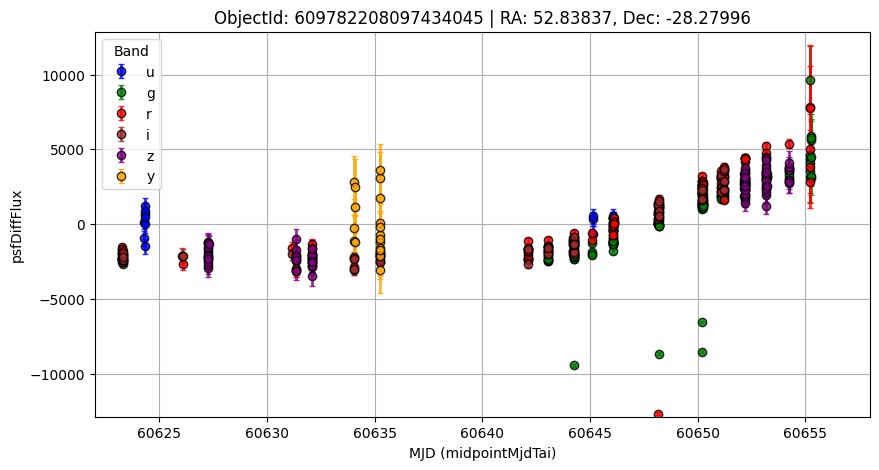

In [24]:


# Extract the nested light curve
first_lc = comcam_cat_single.objectForcedSource.iloc[0]

# Skip if empty
if first_lc is None or first_lc.empty:
    print("No light curve data found.")
else:
    # Optional metadata for the title (if available)
    object_id = comcam_cat_single['objectId'].iloc[0]
    ra = comcam_cat_single['coord_ra'].iloc[0]
    dec = comcam_cat_single['coord_dec'].iloc[0]

    # Compute symmetric y-limits around 0 using 95% range
    flux = first_lc['psfDiffFlux'].dropna()
    if flux.empty:
        print("No valid psfDiffFlux values to plot.")
    else:
        limit = np.percentile(np.abs(flux), 97.5) + 100
        y_min, y_max = -limit, limit

        # Start plot
        plt.figure(figsize=(10, 5))

        # Plot each band with its color
        for band, color in band_colors.items():
            band_data = first_lc[first_lc['band'] == band]
            if band_data.empty:
                continue
            plt.errorbar(
                band_data['midpointMjdTai'],
                band_data['psfDiffFlux'],
                yerr=band_data['psfDiffFluxErr'],
                fmt='o',
                color=color,
                ecolor=color,
                elinewidth=2,
                capsize=2,
                alpha=0.8,
                markeredgecolor='k',
                label=band
            )

        plt.gca().invert_yaxis()
        plt.xlabel('MJD (midpointMjdTai)')
        plt.ylabel('psfDiffFlux')
        plt.title(f'ObjectId: {object_id} | RA: {ra:.5f}, Dec: {dec:.5f}', fontsize=12)
        plt.ylim(y_min, y_max)
        plt.xlim(60622, 60658)
        plt.grid(True)
        plt.legend(title='Band', loc='best')
        plt.show()

Let's go to AGNs. We will select the lightcurves with a particularly large number of detections.

In [25]:
comcam_AGN_many_r = comcam_x_milliquas_computed[comcam_x_milliquas_computed['n_r']>220]
# Display the first objectForcedSource_COM for the first entry in comcam_AGN_many_r
comcam_AGN_many_r.iloc[0]['objectForcedSource_COM']

,band,coord_dec,coord_ra,detector,forcedSourceId,invalidPsfFlag,midpointMjdTai,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,...,pixelFlags_suspectCenter,psfDiffFlux,psfDiffFlux_flag,psfDiffFluxErr,psfFlux,psfFlux_flag,psfFluxErr,psfMag,psfMagErr,visit
0,i,-28.101492,53.29204,4,600320187511610982,False,60623.258521,False,False,False,...,False,-127.501312,False,249.009201,26094.712891,False,247.988312,20.358618,0.010318,2024110800245
1,r,-28.101492,53.29204,4,600320187645828800,False,60623.259329,False,False,False,...,False,-34.913006,False,174.823196,15105.254883,False,173.620209,20.952179,0.012480,2024110800246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,g,-28.101492,53.29204,4,600460950232903586,False,60655.249581,False,False,False,...,False,1457.638672,False,944.030762,4996.374512,False,946.845337,22.153362,0.208272,2024121000433
801,g,-28.101492,53.29204,4,600460950367120759,False,60655.249976,False,False,False,...,False,296.313782,False,599.766541,4181.365723,False,599.424011,22.346704,0.156726,2024121000434


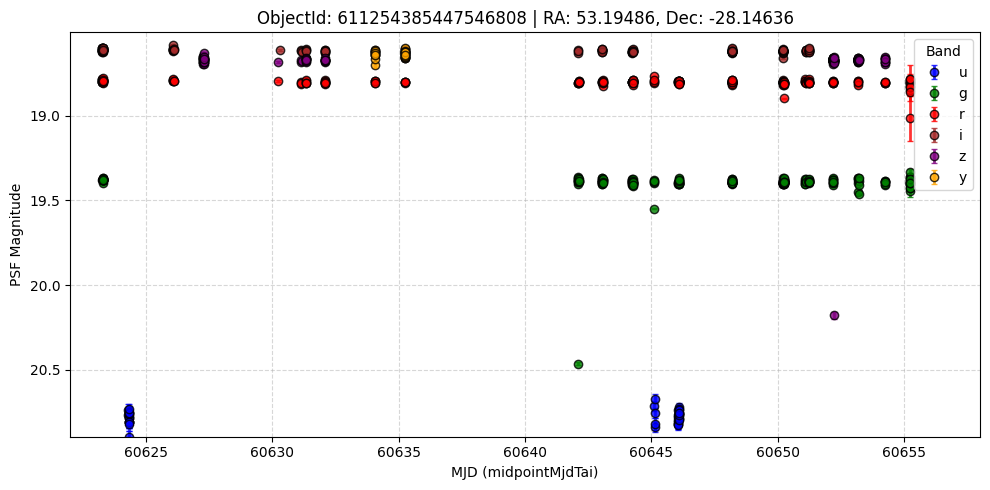

In [26]:
# Extract the nested DataFrame
df_lc = comcam_AGN_many_r.iloc[1]['objectForcedSource_COM']


# Optional metadata (if available)
object_id = comcam_AGN_many_r.iloc[1]['objectId_COM']
ra = comcam_AGN_many_r.iloc[1]['coord_ra_COM']
dec = comcam_AGN_many_r.iloc[1]['coord_dec_COM']



# Compute y-limits from 95% psfMag range (magnitude space)
mag = df_lc['psfMag'].dropna()
if mag.empty:
    print("No valid psfMag values to plot.")
else:
    limit_low = np.percentile(mag, 2.5) - 0.1
    limit_high = np.percentile(mag, 97.5) + 0.1
    y_min, y_max = limit_high, limit_low  # inverted: lower mag = brighter

    # Start plot
    plt.figure(figsize=(10, 5))

    for band, color in band_colors.items():
        df_band = df_lc[df_lc['band'] == band]
        if df_band.empty:
            continue
        plt.errorbar(
            df_band['midpointMjdTai'], 
            df_band['psfMag'], 
            yerr=df_band['psfMagErr'], 
            fmt='o', 
            color=color, 
            ecolor=color, 
            elinewidth=2,
            capsize=2,
            alpha=0.8,
            markeredgecolor='k',
            label=band
        )

    plt.gca().invert_yaxis()
    plt.xlabel("MJD (midpointMjdTai)")
    plt.ylabel("PSF Magnitude")
    plt.title(f'ObjectId: {object_id} | RA: {ra:.5f}, Dec: {dec:.5f}', fontsize=12)
    plt.ylim(y_min, y_max)
    plt.xlim(60622, 60658)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Band", loc='best')
    plt.tight_layout()
    plt.show()

Ok, this is great, but the data has this huge outliers. Let us clear all detections that have any sort of flag associated with them. This will eliminate suspicious detections, especially those with very low detected magnitudes.

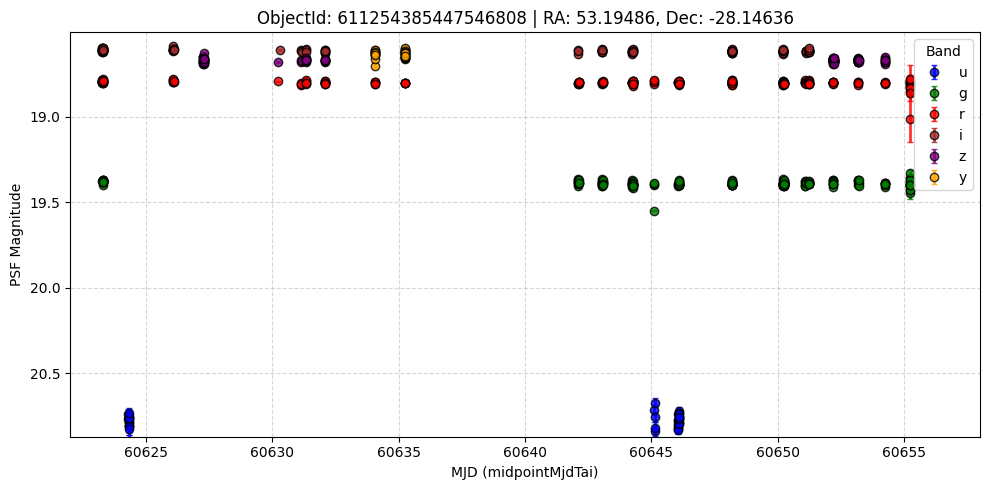

In [27]:

# Extract object metadata
object_id = comcam_AGN_many_r.iloc[1]['objectId_COM']
ra = comcam_AGN_many_r.iloc[1]['coord_ra_COM']
dec = comcam_AGN_many_r.iloc[1]['coord_dec_COM']

# Identify all columns containing "Flag"
flag_cols = [col for col in df_lc.columns if "Flag" in col]

# Keep only rows where all Flag columns are False or NaN
df_lc_clean = df_lc[~df_lc[flag_cols].any(axis=1)]

# Compute y-limits from 95% psfMag range
mag = df_lc_clean['psfMag'].dropna()
if mag.empty:
    print("No valid psfMag values to plot.")
else:
    limit_low = np.percentile(mag, 2.5) - 0.1
    limit_high = np.percentile(mag, 97.5) + 0.1
    y_min, y_max = limit_high, limit_low  # Lower mag = brighter

    # Start plot
    plt.figure(figsize=(10, 5))

    for band, color in band_colors.items():
        df_band = df_lc_clean[df_lc_clean['band'] == band]
        if df_band.empty:
            continue
        plt.errorbar(
            df_band['midpointMjdTai'],
            df_band['psfMag'],
            yerr=df_band['psfMagErr'],
            fmt='o',
            color=color,
            ecolor=color,
            elinewidth=2,
            capsize=2,
            alpha=0.8,
            markeredgecolor='k',
            label=band
        )

    plt.gca().invert_yaxis()
    plt.xlabel("MJD (midpointMjdTai)")
    plt.ylabel("PSF Magnitude")
    plt.title(f'ObjectId: {object_id} | RA: {ra:.5f}, Dec: {dec:.5f}', fontsize=12)
    plt.ylim(y_min, y_max)
    plt.xlim(60622, 60658)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Band", loc='best')
    plt.tight_layout()
    plt.show()

The forced photometry light curve data includes both psfFlux, which represents the measured flux at the source position in the direct image, and psfDiffFlux, which captures the differential flux from the image subtraction process. These two quantities provide complementary views of the object’s brightness: psfFlux reflects the total flux, while psfDiffFlux highlights variability relative to a template. 

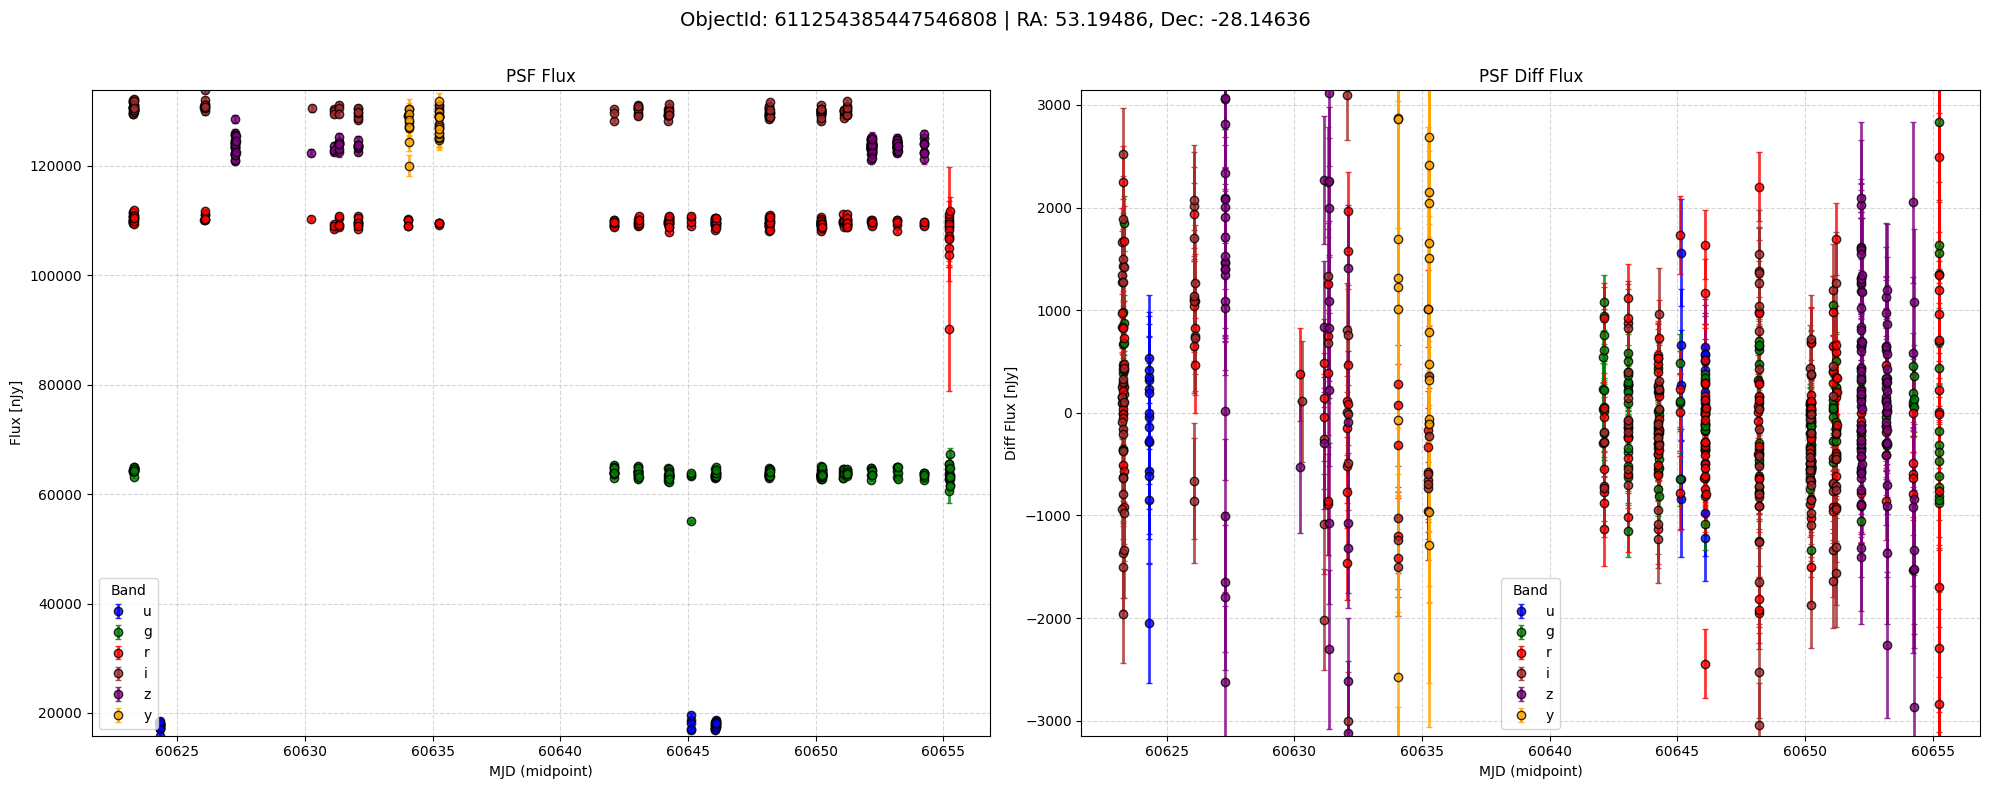

In [28]:

# Extract object metadata
object_id = comcam_AGN_many_r.iloc[1]['objectId_COM']
ra = comcam_AGN_many_r.iloc[1]['coord_ra_COM']
dec = comcam_AGN_many_r.iloc[1]['coord_dec_COM']

# Compute y-limits
flux_vals = df_lc_clean['psfFlux'].dropna()
diff_flux_vals = df_lc_clean['psfDiffFlux'].dropna()

# Skip if nothing to plot
if flux_vals.empty or diff_flux_vals.empty:
    print("No valid flux values to plot.")
else:
    # psfFlux: autoscale
    flux_min, flux_max = flux_vals.min(), flux_vals.max()

    # psfDiffFlux: symmetric around 0 using 95% range
    diff_limit = np.percentile(np.abs(diff_flux_vals), 97.5) + 100
    diff_min, diff_max = -diff_limit, diff_limit

    # Set up subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
    fig.suptitle(f'ObjectId: {object_id} | RA: {ra:.5f}, Dec: {dec:.5f}', fontsize=14)

    for band, color in band_colors.items():
        df_band = df_lc_clean[df_lc_clean['band'] == band]
        if df_band.empty:
            continue

        # Left: psfFlux
        ax1.errorbar(
            df_band['midpointMjdTai'],
            df_band['psfFlux'],
            yerr=df_band['psfFluxErr'],
            fmt='o',
            label=band,
            color=color,
            ecolor=color,
            elinewidth=2,
            capsize=2,
            alpha=0.8,
            markeredgecolor='k'
        )

        # Right: psfDiffFlux
        ax2.errorbar(
            df_band['midpointMjdTai'],
            df_band['psfDiffFlux'],
            yerr=df_band['psfDiffFluxErr'],
            fmt='o',
            label=band,
            color=color,
            ecolor=color,
            elinewidth=2,
            capsize=2,
            alpha=0.8,
            markeredgecolor='k'
        )

    # Format left subplot
    ax1.set_title("PSF Flux")
    ax1.set_xlabel("MJD (midpoint)")
    ax1.set_ylabel("Flux [nJy]")
    ax1.set_ylim(flux_min, flux_max)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(title="Band")

    # Format right subplot
    ax2.set_title("PSF Diff Flux")
    ax2.set_xlabel("MJD (midpoint)")
    ax2.set_ylabel("Diff Flux [nJy]")
    ax2.set_ylim(diff_min, diff_max)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(title="Band")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Structure Function

Finally, let’s compute a basic structure function to characterize the variability amplitude of each object over time.

In [29]:
# Inspired by https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/variable_stars/var_stars_sf.ipynb

from numba import njit

@njit
def calcSF(taumin, taumax, tclip, fclip, nstep):
    dtau = (np.log10(taumax) - np.log10(taumin)) / nstep

    tau1 = np.zeros(nstep)
    tau2 = np.zeros(nstep)
    N = np.zeros(nstep)
    SF = np.zeros(nstep)

    for k in range(nstep):
        tau1[k] = 10**(np.log10(taumin) + k*dtau)
        tau2[k] = 10**(np.log10(tau1[k]) + dtau)
        for i in range(tclip.size):
            dist = tclip[i:] - tclip[i]
            sel = (dist >= tau1[k]) & (dist < tau2[k])
            N[k] += tclip[i:][sel].size
            if tclip[i:][sel].size > 0:
                SF[k] += np.sum((fclip[i:][sel] - fclip[i])**2)
        SF[k] = np.sqrt(SF[k] / N[k]) if N[k] > 0 else np.nan

    return tau1, tau2, SF, N

In [30]:
def compute_structure_function(df, obj_id, nstep=50, Nmin=2):
    """
    Compute the structure function for a single object across all bands.

    Parameters
    ----------
    df : pandas.DataFrame
        The full DataFrame containing `objectId_COM` and `objectForcedSource_COM`.
    obj_id : int
        The objectId_COM to process.
    nstep : int, optional
        Number of time lag bins for the structure function.
    Nmin : int, optional
        Minimum number of point pairs required to include a time bin in the output.

    Returns
    -------
    result : dict
        A dictionary with band as key and a dict of arrays ('tau', 'SF', 'N') as values.
        Example: { 'g': {'tau': ..., 'SF': ..., 'N': ...}, ... }
    """
    result = {}

    obj_data_all = df[df['objectId_COM'] == obj_id]

    if obj_data_all.empty or obj_data_all['objectForcedSource_COM'].isna().iloc[0]:
        return result

    single_lc = obj_data_all['objectForcedSource_COM'].iloc[0]
    if single_lc.empty:
        return result

    for band in sorted(single_lc['band'].unique()):
        filt_data = single_lc[single_lc['band'] == band].dropna(subset=['psfMag', 'midpointMjdTai'])
        if filt_data.empty:
            continue

        filt_data = filt_data.drop_duplicates(subset='midpointMjdTai')
        filt_data = filt_data.sort_values(by='midpointMjdTai')
        mag = filt_data['psfMag'].copy()

        # Iterative 5σ clipping
        count_old = len(mag) + 1
        count = len(mag)
        while count_old > count:
            mag_mean = mag.mean()
            mag_std = mag.std(ddof=1)
            outliers = np.abs(mag - mag_mean) >= 5 * mag_std
            filt_data = filt_data[~outliers]
            mag = filt_data['psfMag']
            count_old = count
            count = len(mag)

        if filt_data.empty or len(mag) < 2:
            continue

        flux = 10**(-0.4 * (mag - np.median(mag)))
        time = filt_data['midpointMjdTai'].to_numpy()

        if len(time) < 2:
            continue

        dtmin = np.min(np.diff(time))
        dtmax = time[-1] - time[0]
        taumin = 2 * dtmin
        taumax = 0.5 * dtmax

        if taumax <= taumin:
            continue

        tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)

        result[band] = {
            'tau': tau1,
            'SF': SF,
            'N': N
        }

    return result


def plot_structure_function(obj_id, sf_data, Nmin=2, band_colors=None, custom_title=None):
    """
    Plot the structure function data for a given object, with connecting lines and visible markers.

    Parameters
    ----------
    obj_id : int or str
        The object ID to include in the plot title.
    sf_data : dict
        Output of `compute_structure_function`. Format: {band: {'tau': ..., 'SF': ..., 'N': ...}}.
    Nmin : int, optional
        Minimum number of point pairs required to include a tau bin in the plot.
    band_colors : dict, optional
        Dictionary mapping bands (e.g. 'g', 'r') to colors.
    """
    if not sf_data:
        print(f"No structure function data for object {obj_id}")
        return

    fig, ax = plt.subplots(figsize=(10, 5))

    lsst_band_order = ['u', 'g', 'r', 'i', 'z', 'y']

    for band in lsst_band_order:
        if band not in sf_data:
            continue
        values = sf_data[band]
        tau = values['tau']
        SF = values['SF']
        N = values['N']

        mask = N > Nmin
        if not np.any(mask):
            continue

        color = band_colors.get(band, None) if band_colors else None
        ax.loglog(
            tau[mask], SF[mask],
            label=band,
            marker='o',
            linestyle='-',
            color=color,
            alpha=0.8,
            markeredgecolor='k',
            markersize=6
        )
        ax.loglog(np.arange(0.001, 25, 0.01), 0.1*np.sqrt(np.arange(0.001, 25, 0.01)/100), color='grey', linestyle='--', alpha=0.5)
        # Use custom title if provided
    if custom_title:
        ax.set_title(custom_title, fontsize=12)
    else:
        ax.set_title(f"Structure Function: ObjectId {obj_id}", fontsize=12)
    ax.set_xlabel("Time lag (days)")
    ax.set_ylabel("Structure Function [mag]")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="Band", loc='best')
    ax.set_ylim(0.005, 0.5)
    plt.tight_layout()
    plt.show()

In [31]:
comcam_AGN_still_many_r = comcam_x_milliquas_computed[(comcam_x_milliquas_computed['n_r']>200) & (comcam_x_milliquas_computed['r_psfMag_COM']<20)]
len(comcam_AGN_still_many_r)

6

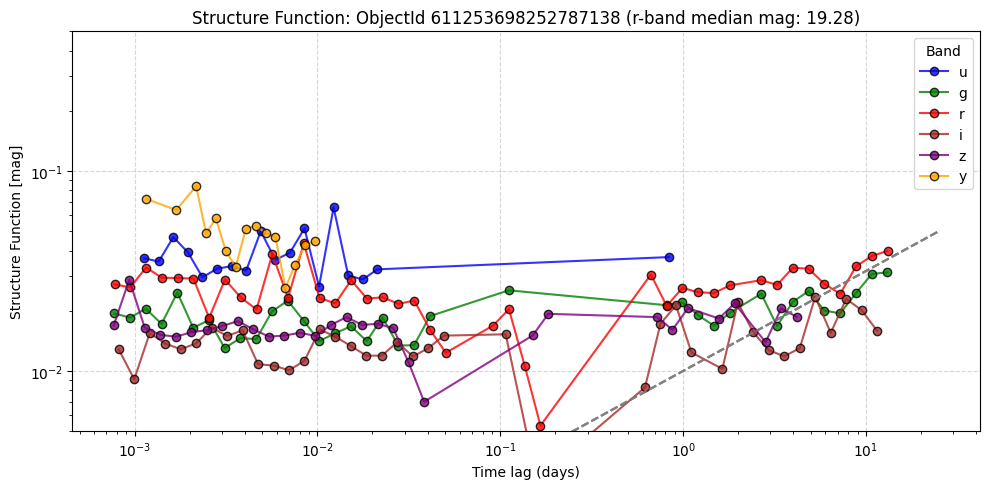

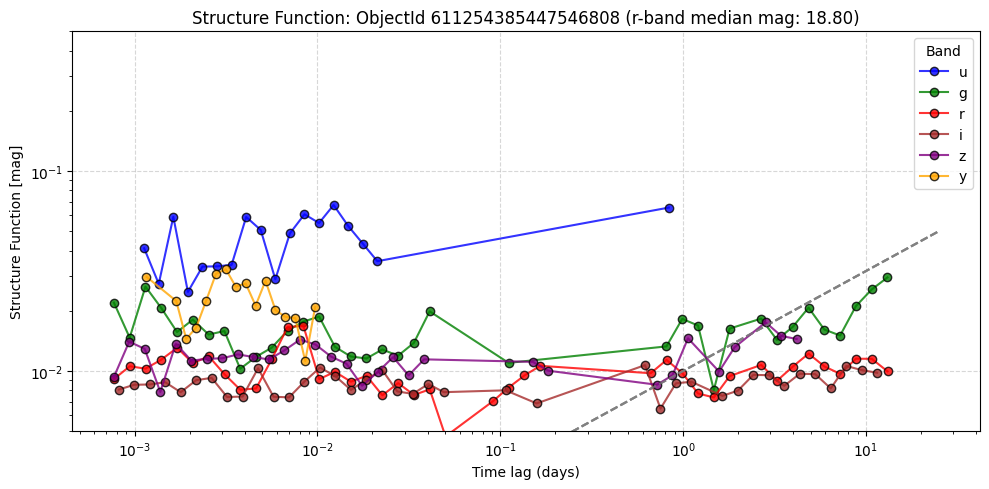

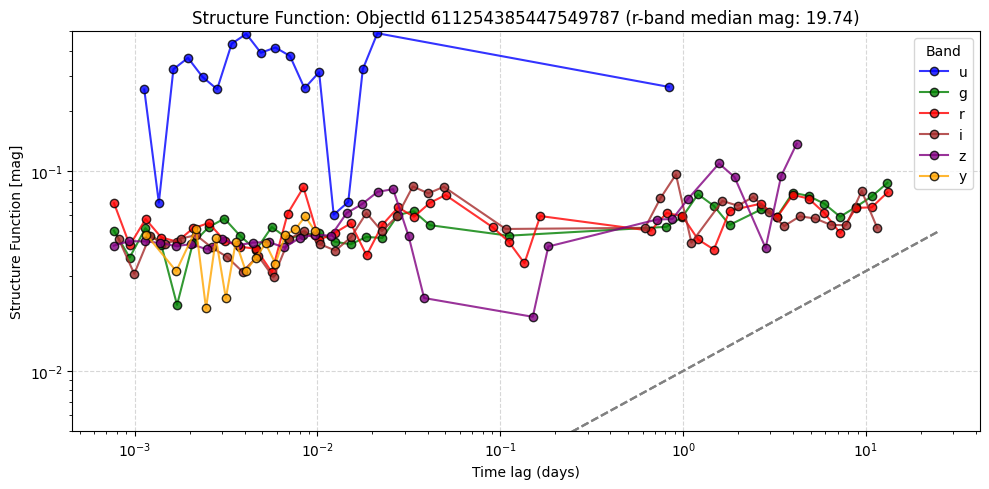

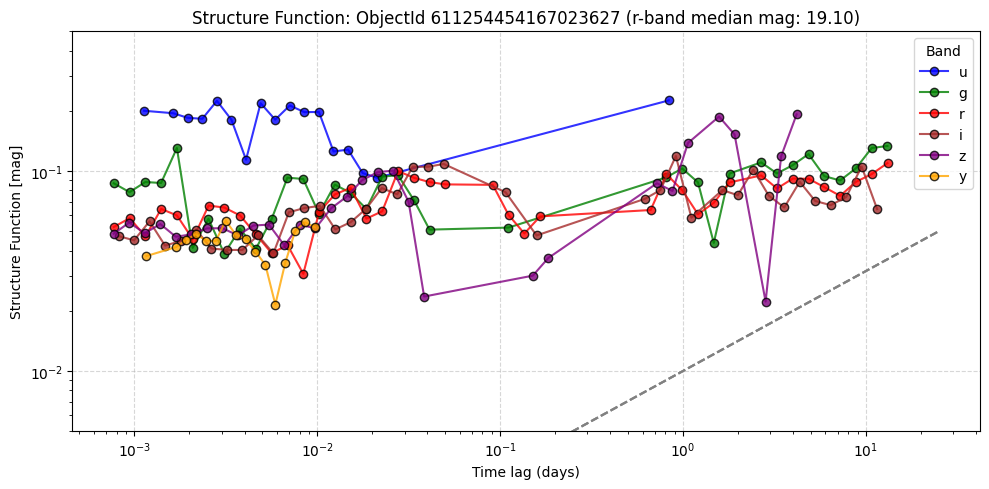

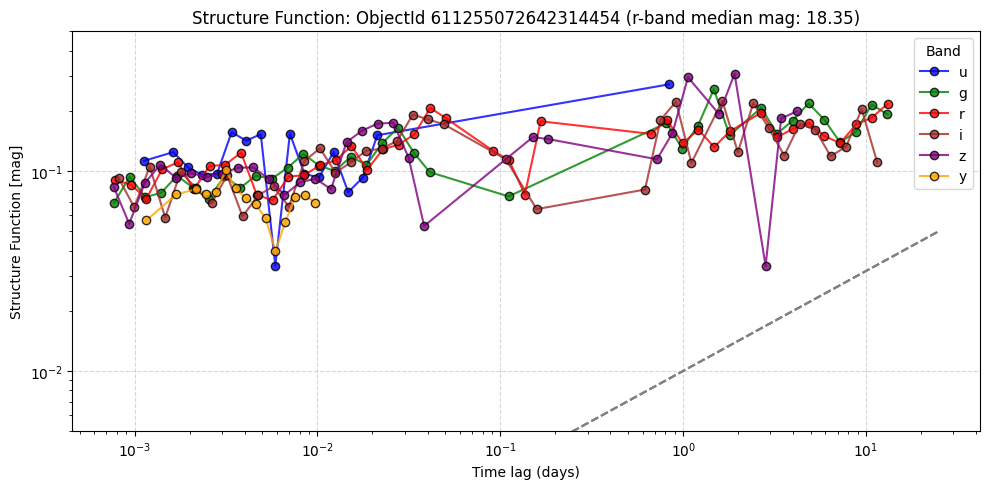

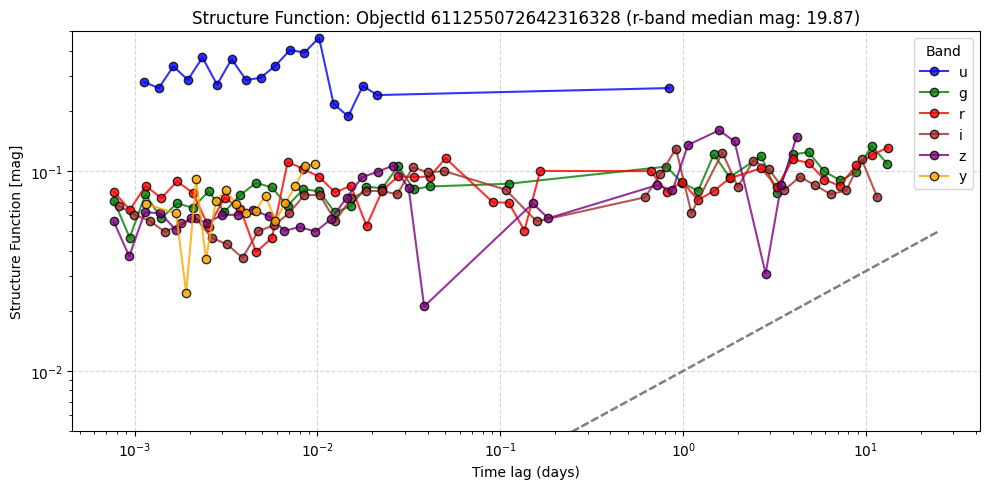

In [32]:
for obj_id in comcam_AGN_still_many_r['objectId_COM'].unique():
    sf_data = compute_structure_function(comcam_AGN_still_many_r, obj_id)

    # Extract r-band median psfMag
    obj_data = comcam_AGN_still_many_r[comcam_AGN_still_many_r['objectId_COM'] == obj_id]
    if obj_data.empty or obj_data['objectForcedSource_COM'].isna().iloc[0]:
        continue

    single_lc = obj_data['objectForcedSource_COM'].iloc[0]
    if single_lc.empty or 'r' not in single_lc['band'].unique():
        continue

    df_r = single_lc[single_lc['band'] == 'r'].dropna(subset=['psfMag'])
    if df_r.empty:
        continue

    median_mag = df_r['psfMag'].median()

    # Plot structure function with magnitude in title
    title = f"Structure Function: ObjectId {obj_id} (r-band median mag: {median_mag:.2f})"
    plot_structure_function(obj_id, sf_data, band_colors=band_colors, custom_title=title)